In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import os
import pandas as pd
import math
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from src.data.preprocessing import sin_cos_angle_inputs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

## Data preparation

In [3]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected.set_index('timestamp', inplace=True)
ss2_selected.index = pd.to_datetime(ss2_selected.index)
SS1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS1_mode.parquet'))
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
FA1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA1_mode.parquet'))
FA2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA2_mode.parquet'))

rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

In [4]:
##Prepare the training and test data

#choose y_ to be SS1_dbscan but uniquely indexed keeping the index with hghest value in size column when duplicated
y_ = ss2_selected.copy()
y_ = y_.sort_values(by=['size'], ascending=False)
y_ = y_.loc[~y_.index.duplicated(keep='last')]
y_ = y_.sort_index()


#Synchronize data
Xy = pd.DataFrame(y_['mean_frequency'])
for col in rfe_selected_data.columns:
    Xy[col] = rfe_selected_data[col]
Xy.dropna(inplace=True)
y = Xy.iloc[:,0]
X_ = Xy[rfe_selected_data.columns]

#preprocess the data
X = sin_cos_angle_inputs(X_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training

In [5]:
# Simple Linear Regression
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
lin_regr_pred = pd.DataFrame(lin_regr.predict(X_test), index=y_test.index, columns=['predictions'])
print('Linear Regression', 'MSE: '+str(mean_squared_error(y_test, lin_regr_pred)), 'R2: '+str(r2_score(y_test, lin_regr_pred)))

Linear Regression MSE: 5.15184140044841e-05 R2: 0.7488304578382061


In [6]:
# Multivariate Linear Regression

mult_lin_regressions = {}
mult_lin_regr_pred = pd.DataFrame(index=y_test.index, columns=['predictions'])
case_lin_regr_pred = {}
caseIDs = pd.read_csv(os.path.join(data_folder, 'interim', 'nw2', 'labeled', loc+turbine+'_case.csv'))
caseIDs.set_index('timestamp', inplace=True)
caseIDs.index = pd.to_datetime(caseIDs.index, utc=True)
for case_ in caseIDs['caseID'].unique():
    try:
        case_lin_regr = LinearRegression()
        case_index = caseIDs[caseIDs['caseID']==case_].index
        case_index_train = case_index[case_index.isin(X_train.index)]
        case_index_test = case_index[case_index.isin(X_test.index)]
        case_lin_regr.fit(X_train.loc[case_index_train], y_train.loc[case_index_train])
        mult_lin_regressions[case_] = case_lin_regr
    except Exception as e1:
        try:
            if math.isnan(case_):
                case_lin_regr = LinearRegression()
                case_index = caseIDs[caseIDs['caseID'].isna()].index
                case_index_train = case_index[case_index.isin(X_train.index)]
                case_index_test = case_index[case_index.isin(X_test.index)]
                case_lin_regr.fit(X_train.loc[case_index_train], y_train.loc[case_index_train])
                mult_lin_regressions[case_] = case_lin_regr
        except Exception as e2:
            print(e1, e2)
            print('Case '+str(case_)+' failed')

Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required by LinearRegression. must be real number, not str
Case High wind: Turbine reducing output power at extreme wind speeds failed


In [7]:
mult_lin_regr_pred = pd.DataFrame(columns=['predictions'])
for case_ in caseIDs['caseID'].unique():
    try:
        case_index = caseIDs[caseIDs['caseID']==case_].index
        case_index_test = case_index[case_index.isin(X_test.index)]
        mult_lin_regr_pred = \
            pd.concat(
                [
                mult_lin_regr_pred,
                pd.DataFrame(mult_lin_regressions[case_].predict(X_test.loc[case_index_test]), index=X_test.loc[case_index_test].index, columns=['predictions'])
                ],
                axis=0)
    except Exception as e1:
        try:
            if math.isnan(case_):
                print(case_)
                case_index = caseIDs[caseIDs['caseID'].isna()].index
                case_index_test = case_index[case_index.isin(X_test.index)]
                mult_lin_regr_pred = \
                    pd.concat(
                        [
                        mult_lin_regr_pred,
                        pd.DataFrame(mult_lin_regressions[case_].predict(X_test.loc[case_index_test]), index=X_test.loc[case_index_test].index, columns=['predictions'])
                        ],
                        axis=0)
        except Exception as e2:
            print(e1, e2)
            print('Case '+str(case_)+' failed')
mult_lin_regr_pred.sort_index(inplace=True)
print('Multivariate Linear Regression', 'MSE: '+str(mean_squared_error(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)), 'R2: '+str(r2_score(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)))

nan
Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required by LinearRegression. must be real number, not str
Case Rated RPM: Turbine rotating at 10.4rpm or 10.445rpm failed
'High wind: Turbine reducing output power at extreme wind speeds' must be real number, not str
Case High wind: Turbine reducing output power at extreme wind speeds failed
Multivariate Linear Regression MSE: 4.5735632263559245e-05 R2: 0.7770234577656351


C:\Users\Max\AppData\Local\Temp\ipykernel_36488\248844592.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pd.concat(
C:\Users\Max\AppData\Local\Temp\ipykernel_36488\248844592.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(


In [8]:
# Random Forest Regression
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, y_train)
rf_regr_pred = pd.DataFrame(rf_regr.predict(X_test), index=y_test.index, columns=['predictions'])

In [9]:
# Gradient Boosting Regression
gb_regr = GradientBoostingRegressor(random_state=42)
gb_regr.fit(X_train, y_train)
gb_regr_pred = pd.DataFrame(gb_regr.predict(X_test), index=y_test.index, columns=['predictions'])

In [10]:
# XGBoost regression
xgb_regr = XGBRegressor()
xgb_regr.fit(X_train, y_train)
xgb_regr_pred = pd.DataFrame(xgb_regr.predict(X_test), index=y_test.index, columns=['predictions'])
print('XGBoost Regression', 'MSE: '+str(mean_squared_error(y_test, xgb_regr_pred)), 'R2: '+str(r2_score(y_test, xgb_regr_pred)))

XGBoost Regression MSE: 4.3883973096042506e-05 R2: 0.7860509170601776


In [11]:
# CatBoost regression
cat_regr = CatBoostRegressor()
cat_regr.fit(X_train, y_train, verbose=False)
cat_regr_pred = pd.DataFrame(cat_regr.predict(X_test), index=y_test.index, columns=['predictions'])
print('CatBoost Regression', 'MSE: '+str(mean_squared_error(y_test, cat_regr_pred)), 'R2: '+str(r2_score(y_test, cat_regr_pred)))

CatBoost Regression MSE: 3.9130410660998764e-05 R2: 0.8092261277788833


In [12]:
# Neural Network
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
mlp_regr = MLPRegressor()
mlp_regr.fit(X_train_scaled, y_train)
mlp_regr_pred = pd.DataFrame(mlp_regr.predict(scaler.transform(X_test)), index=y_test.index, columns=['predictions'])

In [16]:
# Neural Network
def build_model(layers_=[100]):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=layers_[0], activation='relu', input_shape=(len(X.columns),)))
    if len(layers_)>1:
        for layer in layers_[1:]:
            model.add(Dense(units=layer, activation='relu'))
    model.add(Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
nn_regr = build_model()
nn_regr.fit(X_train_scaled, y_train, epochs=20)
nn_regr_pred = pd.DataFrame(nn_regr.predict(scaler.transform(X_test)), index=y_test.index, columns=['predictions'])

nn_regr_2 = build_model([20, 20])
nn_regr_2.fit(X_train_scaled, y_train, epochs=100)
nn_regr_2_pred = pd.DataFrame(nn_regr_2.predict(scaler.transform(X_test)), index=y_test.index, columns=['predictions'])


Epoch 1/20
113/113 [==============================] - 2s 3ms/step - loss: 0.1498 - mean_squared_error: 0.1498
Epoch 2/20
113/113 [==============================] - 0s 2ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 3/20
113/113 [==============================] - 0s 3ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 4/20
113/113 [==============================] - 0s 3ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 5/20
113/113 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 6/20
113/113 [==============================] - 0s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 7/20
113/113 [==============================] - 0s 3ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 8/20
113/113 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 9/20
113/113 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 10/2

Linear Regression MSE: 5.15184140044841e-05 R2: 0.7488304578382061
Multivariate Linear Regression MSE: 4.5735632263559245e-05 R2: 0.7770234577656351
Random Forest Regression MSE: 4.106962652445281e-05 R2: 0.7997718002342844
Gradient Boosting Regression MSE: 4.3060819102693846e-05 R2: 0.790064068777543
XGBoost Regression MSE: 4.3883973096042506e-05 R2: 0.7860509170601776
CatBoost Regression MSE: 3.9130410660998764e-05 R2: 0.8092261277788833
MLP Regression MSE: 0.002939610077393864 R2: -13.33158476518606
Neural Network Regression MSE: 0.0006818559294480576 R2: -2.3242762792516607
Neural Network Regression 2 MSE: 0.0001048887063707309 R2: 0.4886323877364258


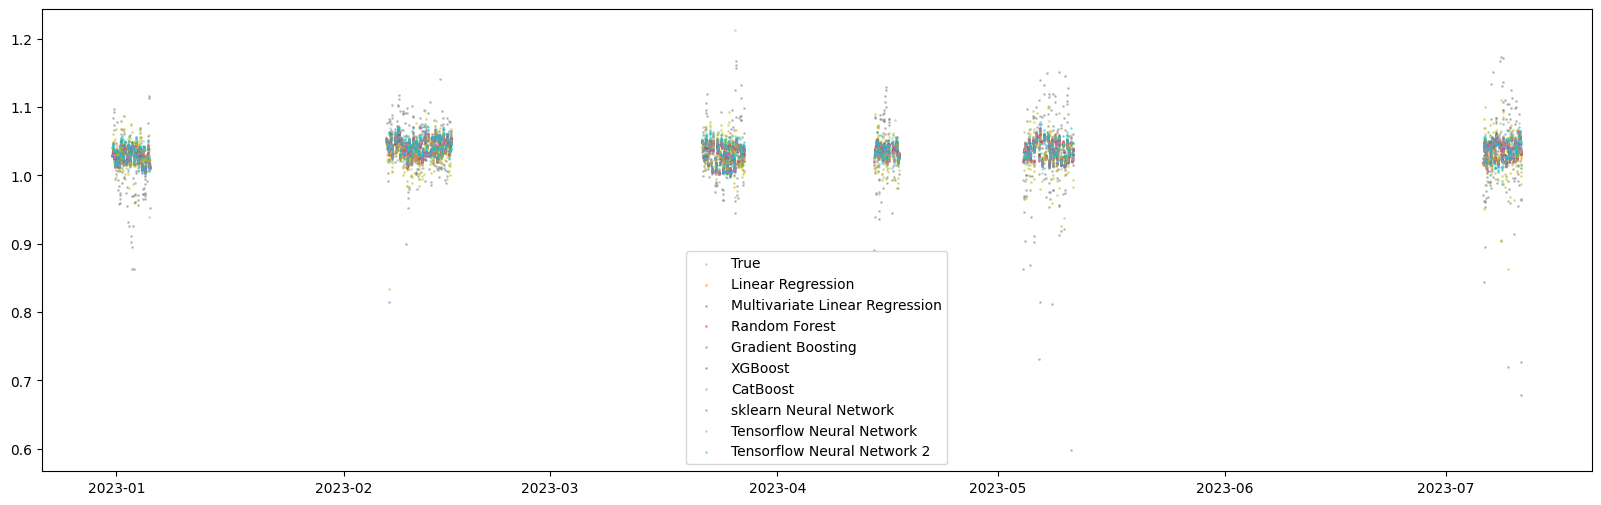

In [17]:
print('Linear Regression', 'MSE: '+str(mean_squared_error(y_test, lin_regr_pred)), 'R2: '+str(r2_score(y_test, lin_regr_pred)))
print('Multivariate Linear Regression', 'MSE: '+str(mean_squared_error(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)), 'R2: '+str(r2_score(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)))
print('Random Forest Regression', 'MSE: '+str(mean_squared_error(y_test, rf_regr_pred)), 'R2: '+str(r2_score(y_test, rf_regr_pred)))
print('Gradient Boosting Regression', 'MSE: '+str(mean_squared_error(y_test, gb_regr_pred)), 'R2: '+str(r2_score(y_test, gb_regr_pred)))
print('XGBoost Regression', 'MSE: '+str(mean_squared_error(y_test, xgb_regr_pred)), 'R2: '+str(r2_score(y_test, xgb_regr_pred)))
print('CatBoost Regression', 'MSE: '+str(mean_squared_error(y_test, cat_regr_pred)), 'R2: '+str(r2_score(y_test, cat_regr_pred)))
print('MLP Regression', 'MSE: '+str(mean_squared_error(y_test, mlp_regr_pred)), 'R2: '+str(r2_score(y_test, mlp_regr_pred)))
print('Neural Network Regression', 'MSE: '+str(mean_squared_error(y_test, nn_regr_pred)), 'R2: '+str(r2_score(y_test, nn_regr_pred)))
print('Neural Network Regression 2', 'MSE: '+str(mean_squared_error(y_test, nn_regr_2_pred)), 'R2: '+str(r2_score(y_test, nn_regr_2_pred)))

plt.figure(figsize=(20,6))
plt.scatter(y_test.index, y_test, s=1, alpha=0.2, label='True')
plt.scatter(lin_regr_pred.index, lin_regr_pred['predictions'], s=1, alpha=0.4, label='Linear Regression')
plt.scatter(mult_lin_regr_pred.index, mult_lin_regr_pred['predictions'], s=1, alpha=0.4, label='Multivariate Linear Regression')
plt.scatter(rf_regr_pred.index, rf_regr_pred['predictions'], s=1, alpha=0.4, label='Random Forest')
plt.scatter(gb_regr_pred.index, gb_regr_pred['predictions'], s=1, alpha=0.4, label='Gradient Boosting')
plt.scatter(xgb_regr_pred.index, xgb_regr_pred['predictions'], s=1, alpha=0.4, label='XGBoost')
plt.scatter(cat_regr_pred.index, cat_regr_pred['predictions'], s=1, alpha=0.4, label='CatBoost')
plt.scatter(mlp_regr_pred.index, mlp_regr_pred['predictions'], s=1, alpha=0.4, label='sklearn Neural Network')
plt.scatter(nn_regr_pred.index, nn_regr_pred['predictions'], s=1, alpha=0.4, label='Tensorflow Neural Network')
plt.scatter(nn_regr_2_pred.index, nn_regr_2_pred['predictions'], s=1, alpha=0.4, label='Tensorflow Neural Network 2')
plt.legend()
plt.show()
plt.close()

# Hyperparameter Optimize

In [18]:
#Hyperparameter optimization: Bayesian optimization
#Hyperopt functions for hyperparameter optimizations
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from src.models.utils import convert_dict
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np
XGB_optimizations = {}
mode = 'SS1'

seed = 42
def objective_xgb(space):
    model = XGBRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 colsample_bytree = space['colsample_bytree'],
                                 )
    score = cross_val_score(model,  X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    # We aim to minimize mse 
    return {'loss': -score, 'status': STATUS_OK }
def optimize_xgb(trial):
    space = {
        'n_estimators':hp.uniformint('n_estimators',10,500),
        'max_depth':hp.uniformint('max_depth',2,20),
        'learning_rate':hp.uniform('learning_rate',0.001,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1),
    }
    best = \
        fmin(
            fn = objective_xgb,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 50,
            rstate = np.random.RandomState(seed)
            )
    return best
trial2=Trials()
XGB_optimizations[mode] = optimize_xgb(trial2)
XGB_optimizations[mode] = convert_dict(XGB_optimizations)[mode]

100%|██████████| 50/50 [04:40<00:00,  5.60s/trial, best loss: 4.4001475929268835e-05]


In [19]:
XGB_optimize = XGB_optimizations[mode]
regr_xgb_optimized = \
    XGBRegressor(
        n_estimators = XGB_optimize['n_estimators'],
        max_depth = XGB_optimize['max_depth'],
        learning_rate = XGB_optimize['learning_rate'],
        colsample_bytree = XGB_optimize['colsample_bytree'],
        )
regr_xgb_optimized.fit(X_train, y_train)

regr_xgb_optimized_pred = regr_xgb_optimized.predict(X_test)
regr_xgb_optimized_mse = mean_squared_error(y_test, regr_xgb_optimized_pred)
regr_xgb_optimized_r2 = r2_score(y_test, regr_xgb_optimized_pred)
print("XGBRegressor Optimized MSE:", regr_xgb_optimized_mse, "XGBRegressor Optimized R2:", regr_xgb_optimized_r2)

XGBRegressor Optimized MSE: 4.017706604240629e-05 XGBRegressor Optimized R2: 0.8041233318557319


In [20]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

def objective_catboost(space):
    model = CatBoostRegressor(
        iterations=int(space['iterations']),
        depth=int(space['depth']),
        learning_rate=space['learning_rate'],
        l2_leaf_reg=space['l2_leaf_reg'],
        border_count=int(space['border_count']),
        random_strength=space['random_strength'],
        bagging_temperature=space['bagging_temperature'],
        verbose=False  # to make CatBoost quiet
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return {'loss': -score, 'status': STATUS_OK}

def optimize_catboost(trial):
    space = {
        'iterations': hp.uniformint('iterations', 100, 1000),
        'depth': hp.uniformint('depth', 2, 16),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
        'border_count': hp.uniformint('border_count', 32, 255),
        'random_strength': hp.uniform('random_strength', 0, 20),
        'bagging_temperature': hp.uniform('bagging_temperature', 0, 1)
    }
    best = fmin(
        fn=objective_catboost,
        space=space,
        algo=tpe.suggest,
        trials=trial,
        max_evals=50,
        rstate=np.random.RandomState(seed)
    )
    return best

# Example usage
trial_catboost = Trials()
CatBoost_optimizations = optimize_catboost(trial_catboost)
CatBoost_optimizations = convert_dict(CatBoost_optimizations)
print(CatBoost_optimizations)

# Creating and training the optimized CatBoostRegressor
regr_catboost_optimized = CatBoostRegressor(
    **CatBoost_optimizations,
    verbose=False
)
regr_catboost_optimized.fit(X_train, y_train)

# Prediction and evaluation
regr_catboost_optimized_pred = regr_catboost_optimized.predict(X_test)
regr_catboost_optimized_mse = mean_squared_error(y_test, regr_catboost_optimized_pred)
regr_catboost_optimized_r2 = r2_score(y_test, regr_catboost_optimized_pred)
print("CatBoostRegressor Optimized MSE:", regr_catboost_optimized_mse, "CatBoostRegressor Optimized R2:", regr_catboost_optimized_r2)


100%|██████████| 50/50 [20:36:25<00:00, 1483.70s/trial, best loss: 4.212056235146956e-05]     


AttributeError: 'numpy.float64' object has no attribute 'items'

In [ ]:
CatBoost_optimizations

{'bagging_temperature': 0.0024210148458735647,
 'border_count': 148.0,
 'depth': 9.0,
 'iterations': 404.0,
 'l2_leaf_reg': 9.678586732885769,
 'learning_rate': 0.027465163258532488,
 'random_strength': 13.235228781449614}

In [ ]:
CatBoost_optimizations_dict = {}
CatBoost_optimizations_dict[mode] = CatBoost_optimizations

In [ ]:
CatBoost_optimizations = convert_dict(CatBoost_optimizations_dict)[mode]
print(CatBoost_optimizations)

# Creating and training the optimized CatBoostRegressor
regr_catboost_optimized = CatBoostRegressor(
    **CatBoost_optimizations,
    verbose=False
)
regr_catboost_optimized.fit(X_train, y_train)

# Prediction and evaluation
regr_catboost_optimized_pred = regr_catboost_optimized.predict(X_test)
regr_catboost_optimized_mse = mean_squared_error(y_test, regr_catboost_optimized_pred)
regr_catboost_optimized_r2 = r2_score(y_test, regr_catboost_optimized_pred)
print("CatBoostRegressor Optimized MSE:", regr_catboost_optimized_mse, "CatBoostRegressor Optimized R2:", regr_catboost_optimized_r2)


{'bagging_temperature': 0.0024210148458735647, 'border_count': 148, 'depth': 9, 'iterations': 404, 'l2_leaf_reg': 9.678586732885769, 'learning_rate': 0.027465163258532488, 'random_strength': 13.235228781449614}
CatBoostRegressor Optimized MSE: 8.340713102589764e-06 CatBoostRegressor Optimized R2: 0.10561985950550568


In [ ]:
from src.models.learning_rate import *

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import numpy as np
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def create_model(hidden_layers, units, batch_normalization):
    model = Sequential()
    model.add(Dense(units[0], input_dim=X_train.shape[1], activation='relu'))
    if batch_normalization:
        model.add(BatchNormalization())

    for i in range(1, hidden_layers):
        model.add(Dense(units[i], activation='relu'))
        if batch_normalization:
            model.add(BatchNormalization())

    model.add(Dense(1, activation='linear'))  # Assuming a regression problem
    return model

def objective(params):
    model = create_model(params['hidden_layers'], [params['units_1'], params['units_2'], params['units_3']], params['batch_normalization'])
    # Learning rate schedulers
    if params['lr_schedule'] == 'linear':
        lr_scheduler = LinearLearningRateScheduler(params['start_lr'], params['end_lr'], 100)
    elif params['lr_schedule'] == 'sinusoidal':
        lr_scheduler = SinusoidalLearningRateScheduler(params['base_lr'], params['max_lr'], 100)
        
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop], verbose=0)

    score = model.evaluate(X_test, y_test, verbose=0)
    return {'loss': score, 'status': STATUS_OK}

def optimize(hidden_layers):
    space = {
        'hidden_layers': hidden_layers,
        'units_1': hp.uniform('units_1', 32, 256),
        'units_2': hp.uniform('units_2', 32, 256) if hidden_layers > 1 else None,
        'units_3': hp.uniform('units_3', 32, 256) if hidden_layers > 2 else None,
        'batch_normalization': hp.choice('batch_normalization', [False, True]),
        'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01),
        'lr_schedule': hp.choice('lr_schedule', ['constant', 'linear', 'sinusoidal']),
        'start_lr': hp.uniform('start_lr', 0.0001, 0.01),
        'end_lr': hp.uniform('end_lr', 0.0001, 0.01),
        'base_lr': hp.uniform('base_lr', 0.0001, 0.01),
        'max_lr': hp.uniform('max_lr', 0.0001, 0.01),
    }
    trials = Trials()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)
    return best


In [ ]:
best_hyperparams_1_layer = optimize(1)
print("Best Hyperparameters for 1 layer:", best_hyperparams_1_layer)

In [ ]:
best_hyperparams_2_layers = optimize(2)
print("Best Hyperparameters for 2 layers:", best_hyperparams_2_layers)

In [ ]:
best_hyperparams_3_layers = optimize(3)
print("Best Hyperparameters for 3 layers:", best_hyperparams_3_layers)

In [ ]:
from src.models.learning_rate import *
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import numpy as np

def create_model(params):
    model = Sequential()
    model.add(Dense(params['units_1'], input_dim=X_train.shape[1], activation='relu'))
    if params['batch_normalization']:
        model.add(BatchNormalization())
    for i in range(1, params['hidden_layers']):
        model.add(Dense(params['units_' + str(i + 1)], activation='relu'))
        if params['batch_normalization']:
            model.add(BatchNormalization())

    model.add(Dense(1, activation='linear'))  # Assuming a regression problem
    return model

def objective(params):
    model = create_model(params)

    # Learning rate schedulers
    if params['lr_schedule'] == 'linear':
        lr_scheduler = LinearLearningRateScheduler(params['start_lr'], params['end_lr'], 100)
    elif params['lr_schedule'] == 'sinusoidal':
        lr_scheduler = SinusoidalLearningRateScheduler(params['base_lr'], params['max_lr'], 100)

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop, lr_scheduler], verbose=0)

    score = model.evaluate(X_test, y_test, verbose=0)
    return {'loss': score, 'status': STATUS_OK}

def optimize():
    space = {
        'hidden_layers': hp.choice('hidden_layers', [1, 2, 3]),
        'units_1': hp.uniform('units_1', 32, 256),
        'units_2': hp.uniform('units_2', 32, 256),
        'units_3': hp.uniform('units_3', 32, 256),
        'batch_normalization': hp.choice('batch_normalization', [False, True]),
        'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01),
        'lr_schedule': hp.choice('lr_schedule', ['constant', 'linear', 'sinusoidal']),
        'start_lr': hp.uniform('start_lr', 0.0001, 0.01),
        'end_lr': hp.uniform('end_lr', 0.0001, 0.01),
        'base_lr': hp.uniform('base_lr', 0.0001, 0.01),
        'max_lr': hp.uniform('max_lr', 0.0001, 0.01),
    }
    trials = Trials()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)
    return best

best_hyperparams = optimize()
print(best_hyperparams)
